In [1]:
import numpy as np
import sys
import torch
from functools import partial
from matplotlib import pyplot as plt
from prob_mbrl import train_regressor, losses, models
torch.set_num_threads(2)

In [2]:
# build model
n_layers = 4
layer_width = 200
drop_rate = 0.5
odims = 1

# single gaussian output model
model = models.Regressor(
    models.dropout_mlp(
        1, 2*odims, [layer_width]*n_layers,
        nonlin=torch.nn.ReLU,
        weights_initializer=partial(torch.nn.init.xavier_normal_,
                                    gain=torch.nn.init.calculate_gain('relu')),
        biases_initializer=partial(torch.nn.init.uniform_, a=-1.0, b=1.0),
        dropout_layers=[models.CDropout(drop_rate, temperature=0.1)]*n_layers),
        output_density=models.DiagGaussianDensity(odims))

# mixture density network
n_components = 5
mmodel = models.Regressor(
    models.dropout_mlp(
        1, 2*n_components*odims + n_components, [layer_width]*n_layers,
        nonlin=torch.nn.ReLU,
        weights_initializer=partial(torch.nn.init.xavier_normal_,
                                    gain=torch.nn.init.calculate_gain('relu')),
        biases_initializer=partial(torch.nn.init.uniform_, a=-1.0, b=1.0),
        dropout_layers=[models.CDropout(drop_rate, temperature=0.1)]*n_layers),
        output_density=models.MixtureDensity(odims, n_components))

# optimizer for single gaussian model
params = filter(lambda p: p.requires_grad, model.parameters())
opt1 = torch.optim.Adam(params, 1e-3, amsgrad=True)

# optimizer for mixture density network
params = filter(lambda p: p.requires_grad, mmodel.parameters())
opt2 = torch.optim.Adam(params, 1e-3, amsgrad=True)

N_ensemble = 100

In [3]:
# create training dataset
def f(x):
    k = 1 #np.random.choice([-1, 1], x.shape[0])
    return k*sum([np.sin(-2*np.pi*(2*k-1)*x)/(2*k-1) for k in range(1, 3)])

train_x = np.concatenate([np.arange(-0.6,-0.25,0.01), np.arange(0.1,0.25,0.01), np.arange(0.1,0.25,0.01),
                          np.arange(0.65,1.0,0.01)])
train_y = f(train_x)
train_y += 0.01*np.random.randn(*train_y.shape)
X = torch.from_numpy(train_x[:, None])
Y = torch.from_numpy(train_y[:, None])

model.set_dataset(X, Y)
model = model.float()
mmodel.set_dataset(X, Y)
mmodel = mmodel.float()
print 'Dataset size:', train_x.shape[0], 'samples'

Dataset size: 100 samples


In [14]:
train_regressor(model, iters=5000, batchsize=N_ensemble, resample=True,
                optimizer=opt1)
train_regressor(mmodel, iters=5000, batchsize=N_ensemble, resample=True,
                optimizer=opt2, log_likelihood=losses.gaussian_mixture_log_likelihood)

log-likelihood of data: 1.168610: 100%|██████████| 5000/5000 [02:49<00:00, 29.50it/s]


In [15]:
# evaluate single gaussian model
test_x = np.arange(-1.8,2.3,0.01)
ret = []
#model.model.resample()
for i, x in enumerate(test_x):
    x = torch.tensor(x[None]).float()
    outs = model(x.expand((N_ensemble, 1)), resample=False)
    y = torch.cat(outs[:2], -1)
    ret.append(y.cpu().detach().numpy())
    torch.cuda.empty_cache()
ret = np.stack(ret)
ret = ret.transpose(1, 0, 2)
torch.cuda.empty_cache()
import gc
for i in range(3):
    gc.collect()

Text(0,0.5,'$f(s_t, a_t) - s_t$')

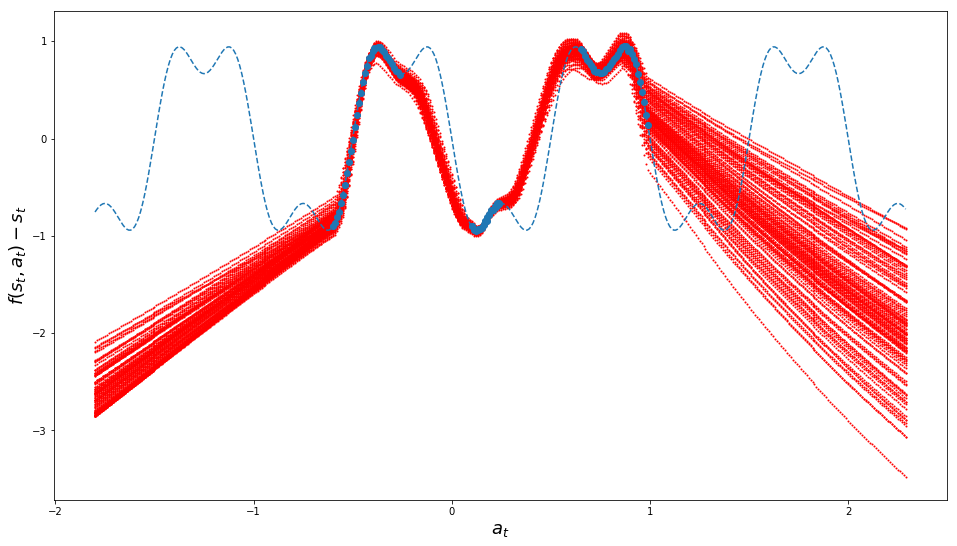

In [16]:
plt.figure(figsize=(16,9))
nc = ret.shape[-2]
colors = list(plt.cm.rainbow_r(np.linspace(0, 1, nc)))

def gaussian_sample(mu, sigma):
    z2 = np.random.randn(*mu.shape[:-1])
    return mu + z2*sigma

for i in range(len(ret)):
    m, S = ret[i, :, 0], ret[i, :, 1]
    samples = gaussian_sample(m, S)
    plt.scatter(test_x, samples, c=colors[0], s=1)
    #plt.fill_between(test_x, m-S, m+S, color='red', linestyle='--', linewidth=1, alpha = 0.3)
m = ret[:, :, 0].mean(0)
S = ret[:, :, 0].std(0)
#plt.plot(test_x, m, label='nn%d' % i, color='red', linestyle='--', linewidth=2)
#plt.fill_between(test_x, m-S, m+S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.5)
#plt.fill_between(test_x, m-2*S, m+2*S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.25)
plt.plot(test_x, f(test_x), linestyle='--', label='true function')
plt.scatter(X.cpu().numpy().flatten(), Y.cpu().numpy().flatten())
plt.xlabel('$a_t$', fontsize=18)
plt.ylabel('$f(s_t, a_t) - s_t$', fontsize=18)
#plt.legend()

In [17]:
# evaluate mixture density network
test_x = np.arange(-1.8,2.3,0.01)
ret = []
weights = []
#mmodel.model.resample()
for i, x in enumerate(test_x):
    x = torch.tensor(x[None]).float()
    outs = mmodel(x.expand((N_ensemble, 1)), resample=False)
    y = torch.cat(outs[:2], -1)
    ret.append(y.cpu().detach().numpy())
    weights.append(outs[2].cpu().detach().numpy())
    torch.cuda.empty_cache()
ret = np.stack(ret)
ret = ret.transpose(1, 0, 2, 3)
weights = np.stack(weights)
weights = weights.transpose(1, 0, 2)
torch.cuda.empty_cache()
import gc
for i in range(3):
    gc.collect()

Text(0,0.5,'$f(s_t, a_t) - s_t$')

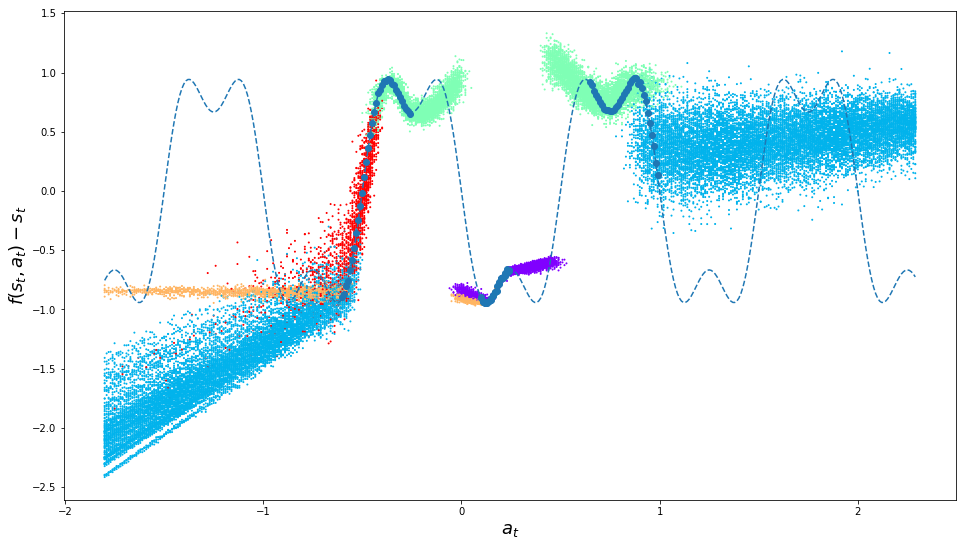

In [18]:
plt.figure(figsize=(16,9))
nc = ret.shape[-2]
colors = np.array(list(plt.cm.rainbow_r(np.linspace(0, 1, nc))))

def mixture_sample(mu, sigma, pi, colors=None):
    z1 = np.random.rand(*mu.shape)
    z2 = np.random.randn(*mu.shape[:-1])
    k = (np.log(pi) + z1).argmax(-1)
    idx = np.arange(len(mu))
    if colors is not None:
        return mu[idx, k] + z2*sigma[idx, k], colors[k]
    return mu[idx, k] + z2*sigma[idx, k]

for i in range(len(ret)):
    m, S = ret[i, :, :, 0], ret[i, :, :, 1]
    samples, c = mixture_sample(m, S, weights[i], colors)
    plt.scatter(test_x, samples, c=c, s=1)
m = ret[:, :, 0].mean(0)
S = ret[:, :, ].std(0)
#plt.plot(test_x, m, label='nn%d' % i, color='red', linestyle='--', linewidth=2)
#plt.fill_between(test_x, m-S, m+S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.5)
#plt.fill_between(test_x, m-2*S, m+2*S, label='nn%d' % i, color='red', linestyle='--', linewidth=2, alpha = 0.25)
plt.plot(test_x, f(test_x), linestyle='--', label='true function')
plt.scatter(X.cpu().numpy().flatten(), Y.cpu().numpy().flatten())
plt.xlabel('$a_t$', fontsize=18)
plt.ylabel('$f(s_t, a_t) - s_t$', fontsize=18)
#plt.legend()